In [10]:
!pip install -Uqq fastbook

In [11]:
from fastbook import *

In [12]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [13]:
results = search_images_ddg('grizzly bear', max_images=150)
len(results)

150

In [14]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [15]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

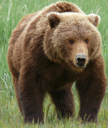

In [16]:
im = Image.open(dest)
im.to_thumb(128,128)

In [17]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [32]:
if not path.exists():
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

In [35]:
fns = get_image_files(path)
fns

(#528) [Path('bears/grizzly/1d61d675-91c2-4dd0-9582-9b795a326c48.jpg'),Path('bears/grizzly/f37e9b16-641b-418f-8715-fa4dd96c556a.jpg'),Path('bears/grizzly/00366a08-c96e-46e3-bba7-367b7838f29f.jpg'),Path('bears/grizzly/65a23573-2a49-4a43-9b23-8380b057bcda.jpg'),Path('bears/grizzly/d8bf711b-c944-48b2-ae89-90232bd930bb.jpg'),Path('bears/grizzly/437d2441-ff8c-4510-a1d8-1acd500d2a0e.jpg'),Path('bears/grizzly/6ba28ca5-64ef-4087-9bf0-564b467d5a3b.jpg'),Path('bears/grizzly/87f7e7f2-ab64-4c5d-8877-4ce61ced82f0.jpg'),Path('bears/grizzly/545891fe-d37e-4f49-8eb6-7f46b8d719d7.jpg'),Path('bears/grizzly/9ca6d002-49dc-4d0a-8cda-1631be3610ee.jpg')...]

In [36]:
failed = verify_images(fns)
failed

(#0) []

In [37]:
failed.map(Path.unlink)

(#0) []

In [42]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128, method='squish')
).dataloaders(path)

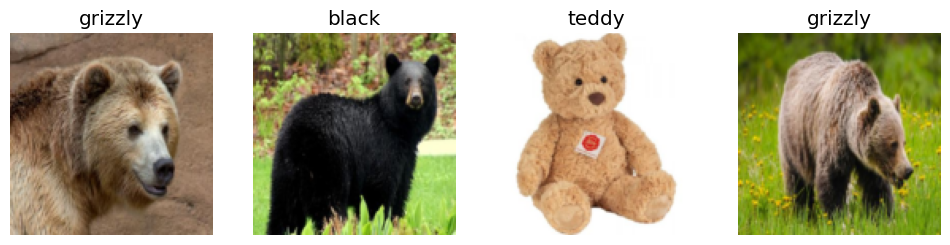

In [43]:
bears.show_batch(max_n=4, nrows=1)

In [44]:
learn = vision_learner(bears, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/slf188/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/slf188/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/slf188/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.231938,0.209840,0.047619,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.320977,0.143485,0.047619,02:39
1,0.216409,0.097225,0.038095,00:50
2,0.162820,0.095587,0.019048,00:26
3,0.127049,0.096501,0.019048,00:20


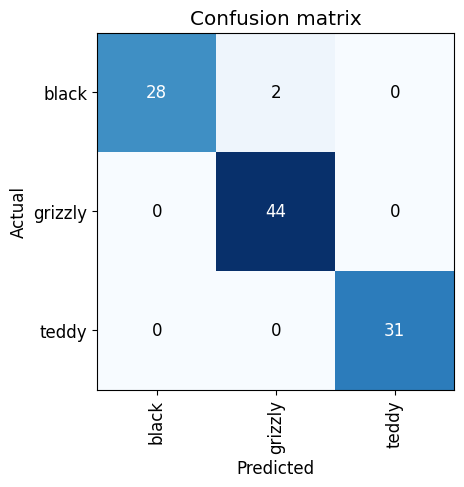

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

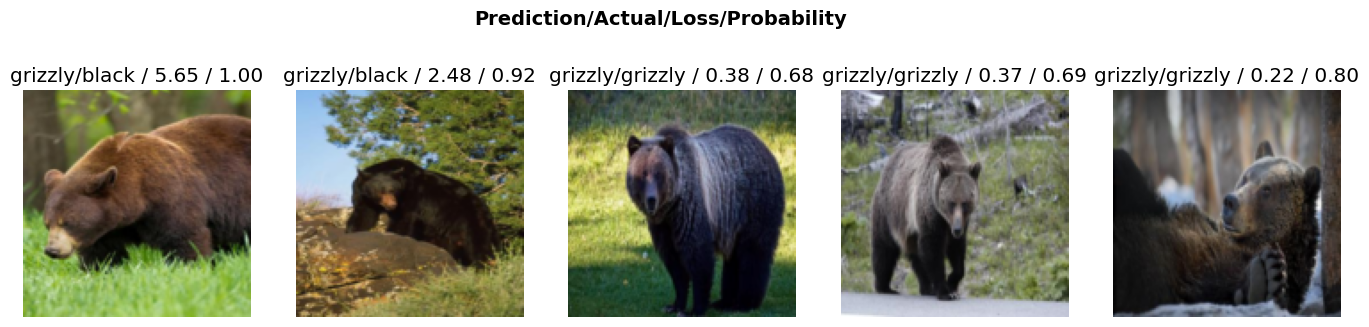

In [47]:
interp.plot_top_losses(5, nrows=1, figsize=(17, 4))

In [48]:
from fastai.vision.widgets import *

In [49]:
# here we manually do some cleaning in our data!
cleaner = ImageClassifierCleaner(learn)
cleaner

In [50]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [51]:
learn.export()

In [52]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [53]:
learn_inf = load_learner(path/'export.pkl')

In [54]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([0.0015, 0.9929, 0.0056]))

In [55]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [58]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [91]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: 
    display(img.to_thumb(128, 128))
out_pl

Output()

In [92]:
pred, pred_idx, probs = learn_inf.predict(img)

In [93]:
lbl_pred = widgets.Label()
lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9929')

In [94]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [95]:
def on_click_classify(change):
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [96]:
btn_upload = widgets.FileUpload()

In [97]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [98]:
doc(FileUpload)

FileUpload(*args: Any, **kwargs: Any) -> Any
File upload widget

    This creates a file upload input that allows the user to select
    one or more files to upload. The file metadata and content
    can be retrieved in the kernel.

    Examples
    --------

    >>> import ipywidgets as widgets
    >>> uploader = widgets.FileUpload()

    # After displaying `uploader` and uploading a file:

    >>> uploader.value
    [
      {
        'name': 'example.txt',
        'type': 'text/plain',
        'size': 36,
        'last_modified': datetime.datetime(2020, 1, 9, 15, 58, 43, 321000, tzinfo=datetime.timezone.utc),
        'content': <memory at 0x10c1b37c8>
      }
    ]
    >>> uploader.value[0].content.tobytes()
    b'This is the content of example.txt.
'

    Parameters
    ----------

    accept: str, optional
        Which file types to accept, e.g. '.doc,.docx'. For a full
        description of how to specify this, see
        https://developer.mozilla.org/en-US/docs/Web/HTML/Elemen

In [ ]:
!pip install voila
!sudo jupyter serverextension enable --sys-prefix voila

Defaulting to user installation because normal site-packages is not writeable
[sudo] password for slf188: 